## Linear Discriminant Analysis (LDA) 

#### Supervised data compression

- Technique for feature extraction to increase the computational efficiency and reduce the degree of over-fitting

---
1. Standardize the d-dimensional dataset (d is the number of features).
2. For each class, compute the d-dimensional mean vector.
3. Construct the between-class scatter matrix S.b, and the within-class scatter matrix S.w
4. Compute the eigenvectors and corresponding eigenvalues of the matrix
5. Choose the k eigenvecotrs that correspond to the k largest eigenvalues to construct a d*k- transofmration matrix
6. Project the samples onto the new feature subspace using the transformation matrix W

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the Wine dataset
#df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', header=None)

df_wine = pd.read_csv('data.csv', header=None)

In [2]:
# Process the data into separate training and test sets
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler

X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values

# 70/30 split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Standardize 
sc = StandardScaler()

X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

Calculation of the mean vectors, which we will use to construct the within-class scatter matrix and between-class scatter matrix.

In [3]:
np.set_printoptions(precision=4)
mean_vecs = []

for label in range(1,4):
    mean_vecs.append(np.mean(X_train_std[y_train==label], axis=0))
    
    print('MV %s: %s\n' % (label, mean_vecs[label-1]))

MV 1: [ 0.9259 -0.3091  0.2592 -0.7989  0.3039  0.9608  1.0515 -0.6306  0.5354
  0.2209  0.4855  0.798   1.2017]

MV 2: [-0.8727 -0.3854 -0.4437  0.2481 -0.2409 -0.1059  0.0187 -0.0164  0.1095
 -0.8796  0.4392  0.2776 -0.7016]

MV 3: [ 0.1637  0.8929  0.3249  0.5658 -0.01   -0.9499 -1.228   0.7436 -0.7652
  0.979  -1.1698 -1.3007 -0.3912]



Compute the within-class scatter matrix Sw - This is calculated by summing up the individual scatter matrcies of each individual class

In [4]:
d = 13 # number of fetures

S_W = np.zeros((d, d))

for label, mv in zip(range(1,4), mean_vecs):
    class_scatter = np.zeros((d, d))
    for row in X_train[y_train == label]:
        row, mv = row.reshape(d, 1), mv.reshape(d, 1)
        class_scatter += (row-mv).dot((row-mv).T)
        
    S_W += class_scatter
    
print('Within-class scatter matrix: %sx%s' % (S_W.shape[0], S_W.shape[1]))

Within-class scatter matrix: 13x13


Assumption that the training set is uniformly distributed. This is violated, as shown below

In [5]:
print('Class label distribution: %s' % np.bincount(y_train)[1:])

Class label distribution: [40 49 35]


Therefore; Let's scale the individual scatter matricies, before we sum them up.

In [6]:
d = 13 # number of features

S_W = np.zeros((d, d))

for label, mv in zip(range(1, 4), mean_vecs):
    class_scatter = np.cov(X_train_std[y_train==label].T)
    S_W += class_scatter
    
print('Scaled within-class scatter matrix: %sx%s' % (S_W.shape[0], S_W.shape[1]))

Scaled within-class scatter matrix: 13x13


Compute the between-class scatter matrix

In [23]:
mean_overall = np.mean(X_train_std, axis=0)

d = 13 # number of features

S_B = np.zeros((d, d))

for i, mean_vec in enumerate(mean_vecs):
    n = X_train[y_train == i+1, :].shape[0]
    mean_vec = mean_vec.reshape(d, 1)
    mean_overall = mean_overall.reshape(d, 1)
    
S_B += n * (mean_vec - mean_overall).dot((mean_vec - mean_overall).T)

print('Between-class scatter matrix: %sx%s' % (S_B.shape[0], S_B.shape[1]))

Between-class scatter matrix: 13x13


Compute the eigenpairs, then sort the eigenvalues in descending order.

In [24]:
eigen_vals, eigen_vecs = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))

eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i]) for i in range(len(eigen_vals))]

eigen_pairs = sorted(eigen_pairs, key=lambda k: k[0], reverse=True)

print('Eigenvalues in decreasing order:\n')

for eigen_val in eigen_pairs:
    print(eigen_val[0])

Eigenvalues in decreasing order:

269.799757873
2.81194438296e-14
2.14483178831e-14
1.68689335069e-14
1.68689335069e-14
1.40782997476e-14
1.20113839905e-14
1.20113839905e-14
4.40949335143e-15
4.40949335143e-15
1.95107674682e-15
2.16267478387e-17
0.0


The first two linear discrimants capture about 100% of teh usefull information in the Wine training dataset

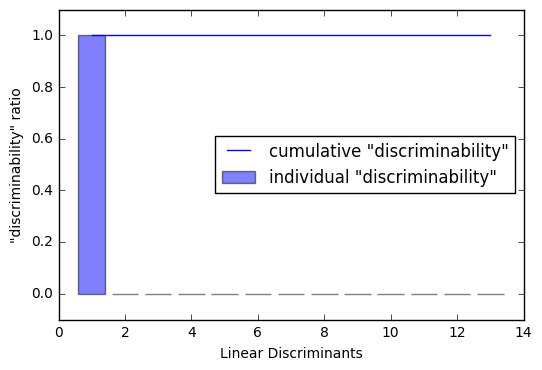

In [25]:
tot = sum(eigen_vals.real)

discr = [(i / tot) for i in sorted(eigen_vals.real, reverse=True)]

cum_discr = np.cumsum(discr)

plt.bar(range(1, 14), discr, alpha=0.5, align='center', label='individual "discriminability"')
plt.step(range(1, 14), cum_discr, where='mid', label='cumulative "discriminability"')

plt.ylabel('"discriminability" ratio')
plt.xlabel('Linear Discriminants')
plt.ylim([-0.1, 1.1])
plt.legend(loc='best')
plt.show()

Stack the two most discriminative eigenvector columns to create transofmration matrix W

In [26]:
w = np.hstack((eigen_pairs[0][1][:, np.newaxis].real, eigen_pairs[1][1][:, np.newaxis].real))

print('Matri W:\n', w)

Matri W:
 [[-0.0102  0.0518]
 [-0.0823  0.0274]
 [-0.0546 -0.2116]
 [-0.122   0.2059]
 [ 0.0062  0.0128]
 [-0.2257  0.1736]
 [ 0.8044 -0.803 ]
 [ 0.0942  0.0446]
 [-0.0508  0.016 ]
 [-0.2398 -0.3253]
 [ 0.1122  0.2249]
 [ 0.3914  0.2727]
 [ 0.2062 -0.035 ]]


Using the transformation matrix, transform the training data by multiplying the matrices.

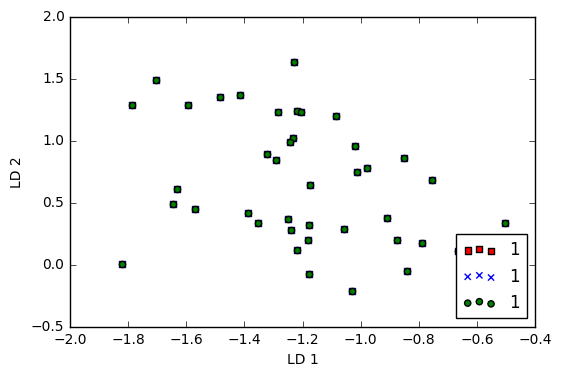

In [28]:
X_train_lda = X_train_std.dot(w)

colors = ['r', 'b', 'g']
markers = ['s', 'x', 'o']

for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_lda[y_train==1, 0]*(-1),
                X_train_lda[y_train==1, 1]*(-1),
                c=c, label=1, marker=m)
    
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc = 'lower right')
plt.show()